## Machine Learning Project | Regression | Ismayil Ismayilov

In [146]:
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, Normalizer, FunctionTransformer, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.dummy import DummyClassifier

import seaborn as sns

import matplotlib.pyplot as plt

%matplotlib inline

## Reading the Data

In [148]:
traffic_df = pd.read_csv('data_explanations/traffic_train.csv', parse_dates=['date_time'])

pd.set_option("display.max_columns",50)
traffic_df.head()

,date_time,weather_general,weather_detailed,clouds_coverage_pct,temperature,rain_mm,snow_mm,traffic
0,2014-10-01 00:00:00,Clear,sky is clear,1,11.5,0.0,0.0,508
1,2014-10-01 01:00:00,Clear,sky is clear,1,10.3,0.0,0.0,323
2,2014-10-01 02:00:00,Clear,sky is clear,1,8.0,0.0,0.0,274
3,2014-10-01 03:00:00,Clear,sky is clear,1,7.9,0.0,0.0,372
4,2014-10-01 04:00:00,Clear,sky is clear,1,6.4,0.0,0.0,812


## Exploratory Data Analysis

### Variables types

Except date_time variable, there are 7 variables. Weather_general and Weather_detailed are categorical variables. Clouds_coverage_pct, temperature, rain_mm, snow_mm, traffic variables are continuous.

In [149]:
traffic_df.dtypes

date_time              datetime64[ns]
weather_general                object
weather_detailed               object
clouds_coverage_pct             int64
temperature                   float64
rain_mm                       float64
snow_mm                       float64
traffic                         int64
dtype: object

### Missing Values

NOTE: First of all, we check the data if there is any missing values. There are 29701 observations without missing values.

In [150]:
traffic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29701 entries, 0 to 29700
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date_time            29701 non-null  datetime64[ns]
 1   weather_general      29701 non-null  object        
 2   weather_detailed     29701 non-null  object        
 3   clouds_coverage_pct  29701 non-null  int64         
 4   temperature          29701 non-null  float64       
 5   rain_mm              29701 non-null  float64       
 6   snow_mm              29701 non-null  float64       
 7   traffic              29701 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(2), object(2)
memory usage: 1.8+ MB


### Outliers

In [151]:
traffic_df.describe()

,clouds_coverage_pct,temperature,rain_mm,snow_mm,traffic
count,29701.000000,29701.000000,29701.000000,29701.000000,29701.000000
mean,50.210027,7.500451,0.509914,0.000361,3228.196761
std,38.657342,13.769115,57.058322,0.010403,1989.059081
min,0.000000,-273.100000,0.000000,0.000000,0.000000
25%,1.000000,-1.300000,0.000000,0.000000,1159.000000
50%,64.000000,8.300000,0.000000,0.000000,3309.000000
75%,90.000000,18.300000,0.000000,0.000000,4918.000000
max,100.000000,35.100000,9831.300000,0.510000,7263.000000


#### Temperature

All variables have minimum 0, except Temperature. The number seems unreal (-271.1). We will check if there is something wrong with the observations.
Another suspicious detail is maximum amount of Rain = 9831.30 MM. We will also check if there is something wrong with the observations.

It seems there are clear outliers in temperature variable. We will clean them.

<AxesSubplot:>

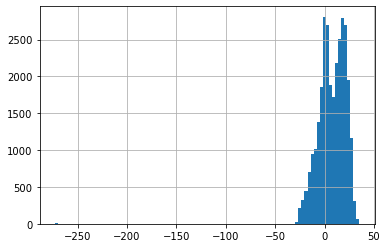

In [152]:
traffic_df.temperature.hist(bins=100)

In [153]:
for x in ['temperature']:
    q75,q25 = np.percentile(traffic_df.loc[:,x],[75,25])
    intr_qr = q75-q25
 
    max = q75+(1.5*intr_qr)
    min = q25-(1.5*intr_qr)
 
    traffic_df.loc[traffic_df[x] < min,x] = np.nan
    traffic_df.loc[traffic_df[x] > max,x] = np.nan

traffic_df = traffic_df.dropna(axis = 0)

<AxesSubplot:>

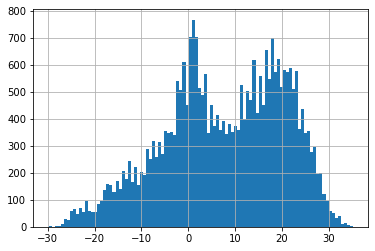

In [154]:
traffic_df.temperature.hist(bins=100)

#### Rainfall

The Density plot does not provide enough data, so we will use another method.

<AxesSubplot:xlabel='rain_mm', ylabel='Density'>

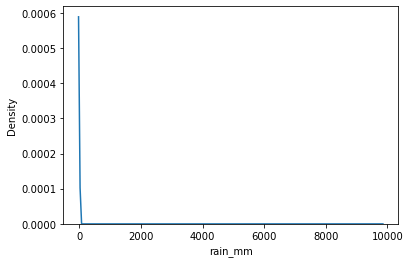

In [155]:
sns.kdeplot(traffic_df['rain_mm'])

We check the highest 5 values in the Rainfall data, so we see one outlier. 9831.3 MM.

In [156]:
traffic_df.nlargest(5, ['rain_mm'])

,date_time,weather_general,weather_detailed,clouds_coverage_pct,temperature,rain_mm,snow_mm,traffic
24857,2018-07-09 17:00:00,Rain,very heavy rain,75,29.0,9831.30,0.0,5531
8232,2015-08-05 02:00:00,Rain,very heavy rain,68,16.0,55.63,0.0,315
7164,2015-06-22 11:00:00,Rain,very heavy rain,76,22.7,44.45,0.0,4804
25764,2018-08-14 17:00:00,Rain,very heavy rain,0,24.6,31.75,0.0,4914
10791,2015-12-17 23:00:00,Rain,very heavy rain,64,-8.6,28.70,0.0,1188


We drop that variable manually since there is only one

In [157]:
traffic_df = traffic_df[traffic_df['rain_mm'] != 9831.3]

#### After Outlier Removal

11 observations have been deleted: 10 observations due to the Temperature outliers, 1 observation due to the Rainfall.

In [158]:
traffic_df.describe()

,clouds_coverage_pct,temperature,rain_mm,snow_mm,traffic
count,29690.000000,29690.000000,29690.000000,29690.000000,29690.000000
mean,50.226103,7.594237,0.178971,0.000361,3228.762243
std,38.653249,12.771607,1.233615,0.010405,1988.896490
min,0.000000,-29.800000,0.000000,0.000000,0.000000
25%,1.000000,-1.200000,0.000000,0.000000,1161.500000
50%,64.000000,8.300000,0.000000,0.000000,3310.500000
75%,90.000000,18.300000,0.000000,0.000000,4918.000000
max,100.000000,35.100000,55.630000,0.510000,7263.000000


### Traffic Data Check
The traffic data is not normally distributed, as we observe in the barblot.
We observe that there is no relationship between years and traffic amount. 2015 is high as 2018 and traffic also decrease from 2016 to 2017.

<AxesSubplot:xlabel='date_time', ylabel='traffic'>

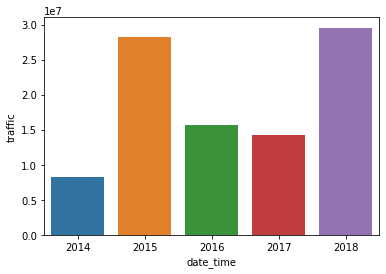

In [159]:
sns.barplot(data=traffic_df, x=traffic_df.date_time.dt.year, y='traffic', estimator=sum, ci=None)

Hourly traffic shows highs between 6-9 AM and 2-5 PM.

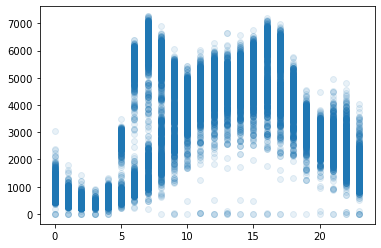

In [160]:
plt.scatter(y = traffic_df["traffic"].values, x=traffic_df.date_time.dt.hour, alpha=0.1)

Weekly traffic shows general consistency over the 52 weeks in a year.

<AxesSubplot:xlabel='week', ylabel='traffic'>

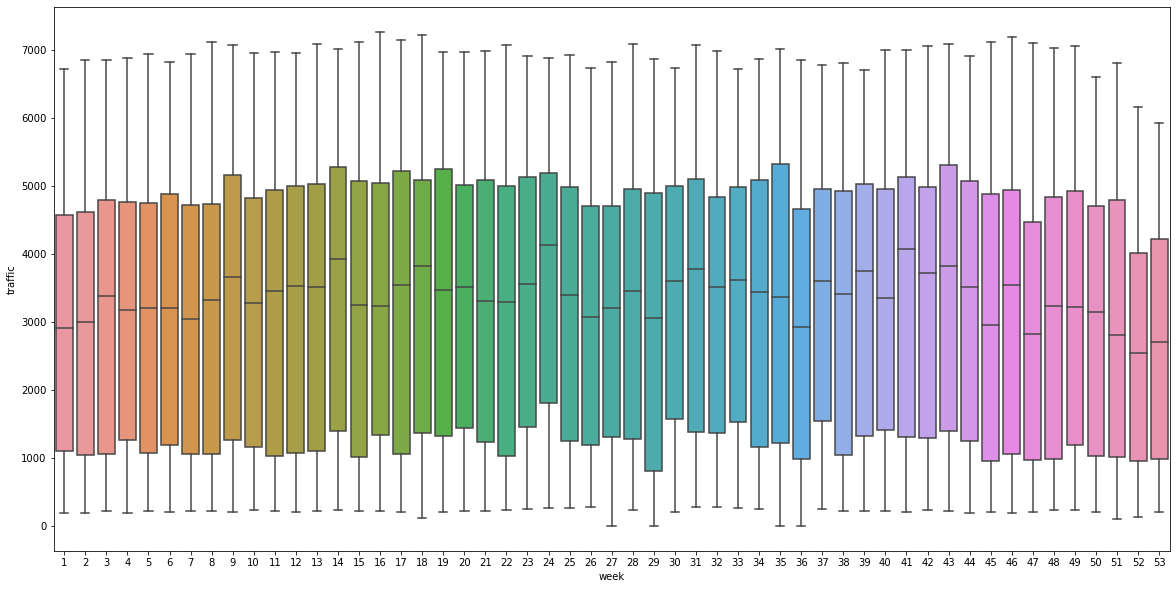

In [161]:
plt.figure(figsize=(20,10))
sns.boxplot(data=traffic_df, y='traffic', x=traffic_df.date_time.dt.isocalendar().week)

#### Checking weather variables

There are 11 weather conditions, but just 4 of them – Cloudy, Clear, Rain, Misty represents 83% of the data.

In [162]:
print(traffic_df['weather_general'].value_counts(normalize=True, sort=True) * 100)

Clouds          34.233749
Clear           27.012462
Rain            11.987201
Mist            11.758168
Snow             6.042439
Drizzle          3.098686
Haze             2.502526
Thunderstorm     1.673964
Fog              1.620074
Smoke            0.057258
Squall           0.013473
Name: weather_general, dtype: float64


## Feature Engineering

Here we divide the date_time variable into more detailed hourly, monthly variables.

In [163]:
def feature(df: pd.DataFrame) -> pd.DataFrame:
    df = df.assign(hour=df['date_time'].dt.hour)
    df = df.assign(month=df['date_time'].dt.month)
    df = df.assign(dayofweek=df['date_time'].dt.dayofweek)
    return df

In [164]:
traffic_df = feature(traffic_df)

In [165]:
traffic_df.describe()

,clouds_coverage_pct,temperature,rain_mm,snow_mm,traffic,hour,month,dayofweek
count,29690.000000,29690.000000,29690.000000,29690.000000,29690.000000,29690.000000,29690.000000,29690.000000
mean,50.226103,7.594237,0.178971,0.000361,3228.762243,11.411216,6.907006,2.999966
std,38.653249,12.771607,1.233615,0.010405,1988.896490,6.945398,3.466047,2.004853
min,0.000000,-29.800000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,1.000000,-1.200000,0.000000,0.000000,1161.500000,5.000000,4.000000,1.000000
50%,64.000000,8.300000,0.000000,0.000000,3310.500000,11.000000,7.000000,3.000000
75%,90.000000,18.300000,0.000000,0.000000,4918.000000,17.000000,10.000000,5.000000
max,100.000000,35.100000,55.630000,0.510000,7263.000000,23.000000,12.000000,6.000000


## Data split

In [166]:
cat_features = ['weather_general', 'weather_detailed', 'hour', 'month', 'dayofweek']
num_features = ['clouds_coverage_pct', 'temperature', 'rain_mm', 'snow_mm']

target = 'traffic'

X = traffic_df[cat_features + num_features]
y = traffic_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2, test_size=0.1)

X_train_for_mape = X_train[y_train != 0]
y_train_for_mape = y_train[y_train != 0]

X_test_for_mape = X_test[y_test != 0]
y_test_for_mape = y_test[y_test != 0]

## Linear Regression

Linear Regression is a commonly used machine learning algorithm based on supervised learning. The linear regression models a target prediction value based on independent variables. It is mostly used for finding out the relationship between variables and forecasting.

In [167]:
ohe_transformer = OneHotEncoder(drop='first', handle_unknown='ignore')
scaler = MinMaxScaler()
transformers = ColumnTransformer([('categorical', ohe_transformer, cat_features),
                                  ('numeric', scaler, num_features)], remainder='passthrough')
linreg_pipeline = Pipeline(steps=[('transform', transformers),
                                  ('logreg', LinearRegression())])

In [168]:
linreg_pipeline.fit(X_train, y_train)

Pipeline(steps=[('transform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['weather_general',
                                                   'weather_detailed', 'hour',
                                                   'month', 'dayofweek']),
                                                 ('numeric', MinMaxScaler(),
                                                  ['clouds_coverage_pct',
                                                   'temperature', 'rain_mm',
                                                   'snow_mm'])])),
                ('logreg', LinearRegression())])

In [169]:
MAPE = mean_absolute_percentage_error(y_train_for_mape, linreg_pipeline.predict(X_train_for_mape))

print ("The MAPE for Y_TRAIN is =",MAPE)

The MAPE for Y_TRAIN is = 1.1286007260402937


In [170]:
MAPE2 = mean_absolute_percentage_error(y_test_for_mape, linreg_pipeline.predict(X_test_for_mape))
print ("The MAPE for Y_TEST is =", MAPE2)

The MAPE for Y_TEST is = 0.49330506799610474


## SVM

Support Vector Machines are one of the most popular and widely used algorithm for dealing with both regression and classification problems in machine learning.

In [108]:
ohe_transformer = OneHotEncoder(drop='first', handle_unknown='ignore')
scaler = MinMaxScaler()
transformers = ColumnTransformer([('categorical', ohe_transformer, cat_features),
                                  ('numeric', scaler, num_features)], remainder='passthrough')
svm_pipeline = Pipeline(steps=[('transform', transformers),
                                  ('logreg', SVR(kernel='rbf'))])

In [109]:
svm_pipeline.fit(X_train, y_train)

Pipeline(steps=[('transform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['weather_general',
                                                   'weather_detailed', 'hour',
                                                   'month', 'dayofweek']),
                                                 ('numeric', MinMaxScaler(),
                                                  ['clouds_coverage_pct',
                                                   'temperature', 'rain_mm',
                                                   'snow_mm'])])),
                ('logreg', SVR())])

In [110]:
MAPE_SVM = mean_absolute_percentage_error(y_train_for_mape, svm_pipeline.predict(X_train_for_mape))
print ("The MAPE for Y_TRAIN is =",MAPE_SVM)

MAPE_SVM2 = mean_absolute_percentage_error(y_test_for_mape, svm_pipeline.predict(X_test_for_mape))
print ("The MAPE for Y_TRAIN is =",MAPE_SVM2)

The MAPE for Y_TRAIN is = 2.6529723409082715
The MAPE for Y_TRAIN is = 1.9799564128623675


## KNN

It is one of the simplest and widely used classification algorithms in which a new data point is classified based on similarity in the specific group of neighboring K data points.

Hyperparameters:
1. K-neighbors - The number of the neighbors
2. knn_p -> Minkowski distance p; the Manhattan distance, p=1 and the Euclidean, p=2 .

In [111]:
ohe_transformer = OneHotEncoder(drop='first', handle_unknown='ignore')
scaler = MinMaxScaler()
transformers = ColumnTransformer([('categorical', ohe_transformer, cat_features),
                                  ('numeric', scaler, num_features)], remainder='passthrough')
knn_pipeline = Pipeline(steps=[('transform', transformers),
                                ('knn', KNeighborsRegressor())])

In [112]:
knn_param_grid = {'knn__n_neighbors': np.arange(10, 31),
                  'knn__p': [1, 2]}

In [113]:
knn_search = GridSearchCV(knn_pipeline, knn_param_grid)

In [114]:
knn_search.fit(X_train, y_train)

/Users/smile/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/smile/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/smile/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/smile/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/smile/opt/anaconda3/lib/python3.8/site-packag

GridSearchCV(estimator=Pipeline(steps=[('transform',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('categorical',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['weather_general',
                                                                          'weather_detailed',
                                                                          'hour',
                                                                          'month',
                                                                          'dayofweek']),
                                                                        ('numeric',
                                                                         MinMaxScaler(),
                                                                         ['clouds_coverage_pct',
                                                                          'temperature',
                                                                          'rain_mm',
                                                                          'snow_mm'])])),
                                       ('knn', KNeighborsRegressor())]),
             param_grid={'knn__n_neighbors': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30]),
                         'knn__p': [1, 2]})

In [116]:
MAPE_KNN = mean_absolute_percentage_error(y_train_for_mape, knn_search.predict(X_train_for_mape))
print ("The MAPE for Y_TRAIN is =",MAPE_KNN)

The MAPE for Y_TRAIN is = 0.9791194986664664


In [117]:
MAPE_KNN_2 = mean_absolute_percentage_error(y_test_for_mape, knn_search.predict(X_test_for_mape))
print ("The MAPE for Y_TEST is =",MAPE_KNN_2)

The MAPE for Y_TEST is = 0.6112642445214393


## Applying the best model on the test data

The best Mean Absolute Percentage Error is given by the KNN Regression. So we will use that model to predict on the TEST data.

1. The MAPE for Y_TRAIN is = 0.9791194986664664
2. The MAPE for Y_TEST is = 0.6112642445214393


In [134]:
traffic_test_df = pd.read_csv('data_explanations/traffic_test.csv', parse_dates=['date_time'])

In [135]:
output_df = pd.DataFrame()
output_df['date_time'] = traffic_test_df['date_time']

No Missing observations in Test Data

In [136]:
traffic_test_df.head()

,date_time,weather_general,weather_detailed,clouds_coverage_pct,temperature,rain_mm,snow_mm
0,2019-01-01 00:00:00,Mist,mist,90,-0.2,0,0
1,2019-01-01 00:00:00,Haze,haze,90,-0.2,0,0
2,2019-01-01 00:00:00,Snow,light snow,90,-0.2,0,0
3,2019-01-01 00:00:00,Drizzle,light intensity drizzle,90,-0.2,0,0
4,2019-01-01 01:00:00,Mist,mist,90,-0.2,0,0


In [137]:
traffic_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10591 entries, 0 to 10590
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date_time            10591 non-null  datetime64[ns]
 1   weather_general      10591 non-null  object        
 2   weather_detailed     10591 non-null  object        
 3   clouds_coverage_pct  10591 non-null  int64         
 4   temperature          10591 non-null  float64       
 5   rain_mm              10591 non-null  int64         
 6   snow_mm              10591 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(2)
memory usage: 579.3+ KB


In [138]:
traffic_test_df = feature(traffic_test_df)

The data seems fine without any outliers.

In [141]:
traffic_test_df.describe()

,clouds_coverage_pct,temperature,rain_mm,snow_mm,hour,month,dayofweek
count,10591.000000,10591.000000,10591.0,10591.0,10591.000000,10591.000000,10591.000000
mean,49.757530,8.243546,0.0,0.0,11.387499,6.465962,2.945709
std,39.545557,11.686270,0.0,0.0,6.962341,3.455361,2.004946
min,0.000000,-27.000000,0.0,0.0,0.000000,1.000000,0.000000
25%,1.000000,0.200000,0.0,0.0,5.000000,4.000000,1.000000
50%,75.000000,9.200000,0.0,0.0,11.000000,6.000000,3.000000
75%,90.000000,17.600000,0.0,0.0,17.000000,9.000000,5.000000
max,92.000000,33.900000,0.0,0.0,23.000000,12.000000,6.000000


In [142]:
X_predict = traffic_test_df[cat_features + num_features]

In [143]:
output_df['traffic'] = knn_search.predict(X_predict)

In [144]:
output_df

,date_time,traffic
0,2019-01-01 00:00:00,555.9
1,2019-01-01 00:00:00,2824.3
2,2019-01-01 00:00:00,1994.4
3,2019-01-01 00:00:00,3181.8
4,2019-01-01 01:00:00,360.0
...,...,...
10586,2019-12-31 19:00:00,1624.6
10587,2019-12-31 20:00:00,2402.3
10588,2019-12-31 21:00:00,2195.3
10589,2019-12-31 22:00:00,1479.6


In [145]:
output_df.to_csv('regression.csv', index=False)